In [1]:
import numpy as np
import xgboost as xgb

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import random

import matplotlib.pyplot as plt
import PIL

In [2]:
# Increase the limit of allowed images size
PIL.Image.MAX_IMAGE_PIXELS = 10e10

In [3]:
# Set the lame names
lames = ["12AG01290_19", "12AG01290_26", "13AG00043_26"]
slide = "PANCKm-CD8r"
label = "Stroma"

# Determine the length of the center square
LENGTH = 2*10**4

In [5]:
# Set the seed
random.seed(42)

# Take a random sample
random_sample = random.sample(population=range(LENGTH**2), k=10**7)

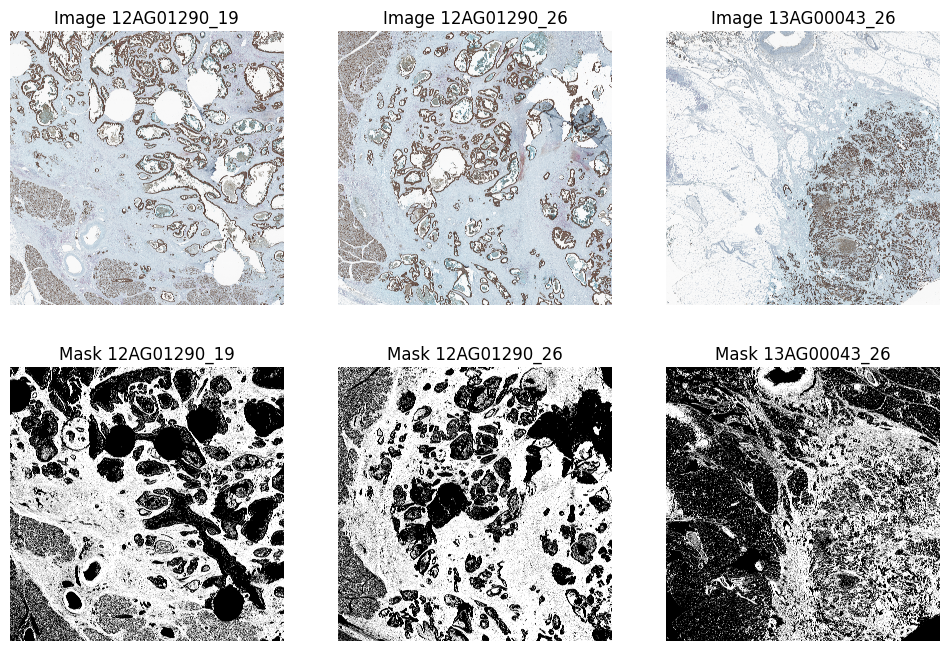

In [6]:
# Plot the image and the mask
fig, ax = plt.subplots(2, len(lames), figsize=(12, 8))
ax.flatten()

features, labels = [], []
for i, lame in enumerate(lames):
    # Load the image
    img = io.imread(f'data/{lame}/results/images_aligned/{slide}.ome.tiff')

    # Load the lebel binary mask
    mask = io.imread(f'data/{lame}/results/masks/{slide}_{label}_mask.png')

    # Determine the center of the image
    center = (int(img.shape[0]/2), int(img.shape[1]/2))

    # Cut the middle part of the image and the mask
    img = img[center[0]-LENGTH:center[0]+LENGTH,
              center[1]-LENGTH:center[1]+LENGTH]
    
    mask = mask[center[0]-LENGTH:center[0]+LENGTH,
                center[1]-LENGTH:center[1]+LENGTH]
    
    # Plot the image and the mask
    ax[0, i].imshow(img)
    ax[0, i].set_title("Image " + lame)
    ax[0, i].axis('off')

    ax[1, i].imshow(mask, cmap='gray')
    ax[1, i].set_title("Mask " + lame)
    ax[1, i].axis('off')

    # Reshape the image and the mask
    X = img.reshape(-1, 3)
    y = mask.reshape(-1)

    # Extract a sample if the mask is balanced
    if 0.1 < np.mean(y) < 0.9:
        X = X[random_sample]
        y = y[random_sample]

    # Get indices of the zero and non-zero elements
    non_zero_indices = np.array(range(y.shape[0]))[y != 0]
    zero_indices = np.array(range(y.shape[0]))[y == 0]

    # Balance the dataset
    if len(non_zero_indices) < len(zero_indices):
        balanced_indices = np.concatenate([non_zero_indices,
                                        random.sample(list(zero_indices),
                                                        len(non_zero_indices))])
    else:
        balanced_indices = np.concatenate([zero_indices,
                                        random.sample(list(non_zero_indices),
                                                        len(zero_indices))])
        
    # Extract the balanced dataset
    features.append(X[balanced_indices])
    labels.append(y[balanced_indices])

plt.show()

In [7]:
# Concatenate the features and the labels
X = np.concatenate(features, dtype=np.float32)
y = np.concatenate(labels, dtype=np.int32)

# Check the shapes
print(X.shape, y.shape)

(24363678, 3) (24363678,)


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Check the shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21927310, 3) (2436368, 3) (21927310,) (2436368,)


In [9]:
# Convert the data into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
# Define XGBoost parameters
params = {'objective':'binary:logistic',
          'max_depth':8,
          'learning_rate':0.1,
          'alpha':10,
          'colsample_bytree':0.9,
          'device':'gpu'}

# Initialize the evals_result dictionary
evals_result = {}

# Train the model with evals_result to store the evaluation results
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=100000,
                  evals=[(dtrain, 'train'), (dtest, 'test')],
                  early_stopping_rounds=10,
                  evals_result=evals_result)

[0]	train-logloss:0.61962	test-logloss:0.61962
[1]	train-logloss:0.56161	test-logloss:0.56162
[2]	train-logloss:0.51327	test-logloss:0.51328
[3]	train-logloss:0.46915	test-logloss:0.46917
[4]	train-logloss:0.42944	test-logloss:0.42945
[5]	train-logloss:0.39771	test-logloss:0.39773
[6]	train-logloss:0.36778	test-logloss:0.36778
[7]	train-logloss:0.34385	test-logloss:0.34385
[8]	train-logloss:0.32316	test-logloss:0.32316
[9]	train-logloss:0.30499	test-logloss:0.30498
[10]	train-logloss:0.28893	test-logloss:0.28892
[11]	train-logloss:0.27230	test-logloss:0.27228
[12]	train-logloss:0.26038	test-logloss:0.26036
[13]	train-logloss:0.24696	test-logloss:0.24694
[14]	train-logloss:0.23772	test-logloss:0.23770
[15]	train-logloss:0.22898	test-logloss:0.22896
[16]	train-logloss:0.21924	test-logloss:0.21922
[17]	train-logloss:0.21286	test-logloss:0.21283
[18]	train-logloss:0.20651	test-logloss:0.20649
[19]	train-logloss:0.20135	test-logloss:0.20132
[20]	train-logloss:0.19689	test-logloss:0.19687
[2

In [11]:
# Make predictions
y_pred = model.predict(dtest)

# Compute and print the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.03840178477386036


In [12]:
# Step 5: Predict and evaluate
y_pred = model.predict(dtest)
y_pred = (y_pred > 0.5).astype(int)

# Compute the intersection over union
from sklearn.metrics import jaccard_score
iou = jaccard_score(y_test, y_pred)

print(f"IoU: {iou:.2f}")

IoU: 0.90


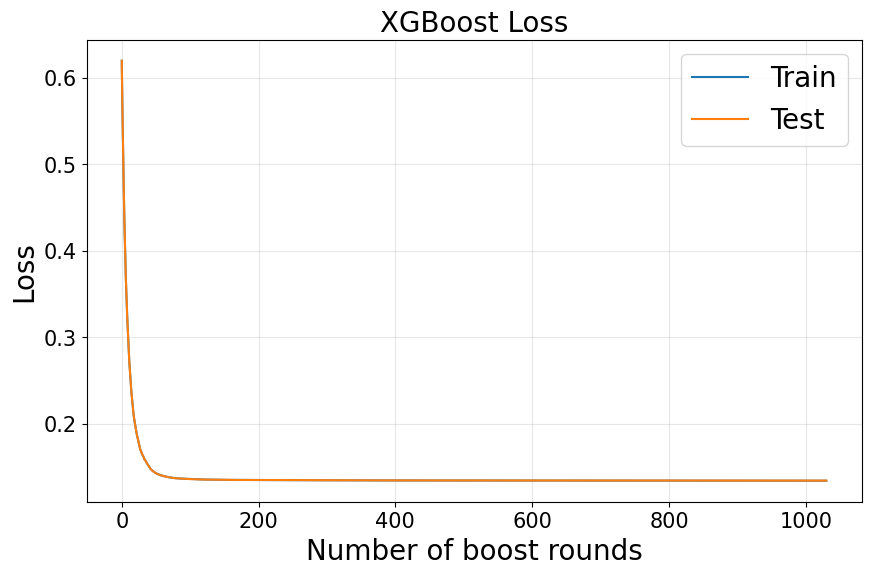

In [13]:
# Plot the training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['logloss'], label='Train')
plt.plot(evals_result['test']['logloss'], label='Test')
plt.legend(fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Number of boost rounds', fontsize=20)
plt.title('XGBoost Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.savefig(f"figures/xgboost_loss_{label}.png")
plt.show()

In [14]:
# Save the model
model.save_model(f"models/xgboost_{label}.model")

/home/vscode/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:54:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
